In [2]:
# Add module folder to notebook
import os
import sys
import pandas
from snowflake.ml.modeling.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv()))

In [48]:
from snowflake.snowpark import functions, Session, types
import datetime

from app.snowpark_session.session import snowpark_session

In [4]:
session = snowpark_session()

In [5]:
session.use_database("HOL_DB")

In [6]:
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "LEIT_WH"


## Explore and Prepare Data

We will use two tables, APPLICATION_RECORD and CREDIT_RECORD, for creating the data set needed for training our model.

In [7]:
# Creating a Snowpark DataFrame
application_record_sdf = session.table('APPLICATION_RECORD')
credit_record_sdf = session.table('CREDIT_RECORD')

### APPLICATION_RECORD

In [8]:
application_record_sdf.count()

438557

#### Remove Duplicates

In [9]:
duplicates_df = application_record_sdf.group_by('ID').agg(functions.count('ID').as_('ID_COUNTS')).filter(functions.col('ID_COUNTS') > 1)
print(f'Total Duplicates: {duplicates_df.count()}')

Total Duplicates: 47


In [10]:
application_record_sdf = application_record_sdf.drop_duplicates('ID')
application_record_sdf.count()

438510

#### Simple Stats


Obtaining simple statistics per column - why are some statistics missing?  
Can you already identify problems in our data?  
For example count always return the number of non null records.  
Hint: ID variables are useless for ML models (but we need it for joining)  
Hint: Missing values for OCCUPATION_TYPE  
Hint: Max Value for DAYS_EMPLOYED seems wrong  

In [11]:
application_record_sdf.describe().to_pandas()

,SUMMARY,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,mean,6.022035e+06,None,None,None,0.427381,1.875254e+05,None,None,None,None,-15998.022996,60566.188769,1.0,0.206128,0.287770,0.108200,None,2.194463
1,count,4.385100e+05,438510,438510,438510,438510.000000,4.385100e+05,438510,438510,438510,438510,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,304317,438510.000000
2,stddev,5.714962e+05,None,None,None,0.724874,1.100893e+05,None,None,None,None,4185.016222,138770.072835,0.0,0.404523,0.452724,0.310633,None,0.897192
3,min,5.008804e+06,F,N,N,0.000000,2.610000e+04,Commercial associate,Academic degree,Civil marriage,Co-op apartment,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,Accountants,1.000000
4,max,7.999952e+06,M,Y,Y,19.000000,6.750000e+06,Working,Secondary / secondary special,Widow,With parents,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,Waiters/barmen staff,20.000000


#### Missing Value Imputation

The describe output show that we have missing values in OCCUPATION_TYPE, it's count are less (304317) than the total count (438557)  
We will use the `fillna' method to replace missing values in OCCUPATION_TYPE with 'OTHER', since they are so many we creates a new category for it. 

In [12]:
application_record_sdf = application_record_sdf.fillna(value='OTHER', subset=['OCCUPATION_TYPE'])
application_record_sdf.describe().to_pandas()

,SUMMARY,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,count,4.385100e+05,438510,438510,438510,438510.000000,4.385100e+05,438510,438510,438510,438510,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,438510,438510.000000
1,mean,6.022035e+06,None,None,None,0.427381,1.875254e+05,None,None,None,None,-15998.022996,60566.188769,1.0,0.206128,0.287770,0.108200,None,2.194463
2,min,5.008804e+06,F,N,N,0.000000,2.610000e+04,Commercial associate,Academic degree,Civil marriage,Co-op apartment,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,Accountants,1.000000
3,stddev,5.714962e+05,None,None,None,0.724874,1.100893e+05,None,None,None,None,4185.016222,138770.072835,0.0,0.404523,0.452724,0.310633,None,0.897192
4,max,7.999952e+06,M,Y,Y,19.000000,6.750000e+06,Working,Secondary / secondary special,Widow,With parents,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,Waiters/barmen staff,20.000000


#### Finding constant variables
How many distinct values do we have per column?  
Hint: Constant values are probably irrelevant  
Hint: Variables with many different values can be problematic

In [13]:
unique_values = []
for column in application_record_sdf.columns:
    unique_values.append([column, application_record_sdf.select(column).distinct().count()])
pandas.DataFrame(unique_values, columns=['COLUMN_NAME','NUM_UNIQUE_VALUES'])

,COLUMN_NAME,NUM_UNIQUE_VALUES
0,ID,438510
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,CNT_CHILDREN,12
5,AMT_INCOME_TOTAL,866
6,NAME_INCOME_TYPE,5
7,NAME_EDUCATION_TYPE,5
8,NAME_FAMILY_STATUS,5
9,NAME_HOUSING_TYPE,6


FLAG_MOBIL has only one value so it will not provide any value, so we will drop it from our dataframe.

In [14]:
application_record_sdf = application_record_sdf.drop('FLAG_MOBIL')

#### Response Variable (Target)  
The target variable (column) is in the credit_record_sdf, CREDIT_RECORD, DataFrame and we want to join it with our application_record_sdf dataFrame. Before doing that we will transform the target column.

The traget column, Status, has multiple values which has the following meanings:  
0: 1-29 days past due  
1: 30-59 days past due  
2: 60-89 days overdue  
3: 90-119 days overdue  
4: 120-149 days overdue  
5: Overdue or bad debts, write-offs for more than 150 days  
C: paid off that month  
X: No loan for the month  

In this case we are only interested to flag customers as either high-risk or low-risk. We have defined that a customer is high-risk (1) if during any month they are late on payments by 60 days or more.
All other customers are low-risk (0).

We start by checking how the distribution is among the different status codes.nt status codes.

In [15]:
credit_record_sdf.group_by('STATUS').count().sort('STATUS').to_pandas()

,STATUS,COUNT
0,0,383120
1,1,11090
2,2,868
3,3,320
4,4,223
5,5,1693
6,C,442031
7,X,209230


We will create a new column, TARGET, that will have a 1 for high-risk and 0 for low-risk.

Since credit_record_sdf is on month level we will aggregate and count the number of late payments by customer, ID, and if they have at least one late payment we set TARGET to 1 otherwise to 0.0.

In [16]:
risk_statuses = ['2', '3', '4', '5']
risk_df = credit_record_sdf.group_by('ID') \
    .agg(functions.sum(functions.iff(functions.col('STATUS').in_(risk_statuses), 1, 0)).as_('CNT_LATE')) \
    .with_column('TARGET', functions.when(functions.col('CNT_LATE') > 0, 1).otherwise(0)) \
    .drop('CNT_LATE')

Check the target distribution  
Hint: Highly imbalanced target variables can be problematicc

In [17]:
risk_df.group_by('TARGET').count().to_pandas()

,TARGET,COUNT
0,0,45318
1,1,667


Join risk_df with application_record_sdf

In [18]:
application_record_sdf = application_record_sdf.join(risk_df, using_columns='ID', join_type='inner')
application_record_sdf.count()

36457

In [19]:
application_record_sdf.limit(10).to_pandas()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5111190,F,N,Y,2,247500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-13019,-2307,0,0,0,OTHER,4.0,0
1,5140183,F,N,Y,0,67500.0,State servant,Secondary / secondary special,Married,Municipal apartment,-15161,-7190,0,0,0,Core staff,2.0,0
2,5033998,F,N,N,0,112500.0,Commercial associate,Secondary / secondary special,Separated,Municipal apartment,-16417,-1615,0,1,0,Laborers,1.0,0
3,5099974,F,N,N,0,180000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10218,-1740,0,1,0,Security staff,2.0,0
4,5095056,F,Y,Y,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22684,365243,0,0,0,OTHER,2.0,0
5,5105697,F,Y,N,0,225000.0,Working,Secondary / secondary special,Married,Municipal apartment,-12155,-667,0,0,0,Laborers,2.0,0
6,5024230,F,Y,Y,0,540000.0,Commercial associate,Higher education,Married,House / apartment,-15702,-185,0,1,0,OTHER,2.0,0
7,5029014,F,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-13868,-415,0,0,0,Laborers,2.0,0
8,5149342,F,Y,Y,0,292500.0,Commercial associate,Higher education,Single / not married,House / apartment,-16930,-8995,0,0,0,High skill tech staff,1.0,0
9,5061967,F,N,Y,0,225000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-22897,-1812,0,0,0,Managers,2.0,0


#### Feature Engineering  
For many ML algorithms we need numeric data, so we'll encode our variables.

We will apply the following techniques:  
| COLUMN | TECHNIQUE |  
|---------------------|--------------------------------------------------------|
| FLAG_OWN_CAR | OrdinalEncoder |
| FLAG_OWN_REALTY | OrdinalEncoder |
| AMT_INCOME_TOTAL | StandardScaler |
| CODE_GENDER | OneHotEncoder |
| NAME_INCOME_TYPE | OneHotEncoder |
| NAME_EDUCATION_TYPE | OneHotEncoder |
| NAME_FAMILY_STATUS | OneHotEncoder |
| NAME_HOUSING_TYPE | OneHotEncoder |
| CNT_CHILDREN | Custom Categories + OneHotEncoder |
| CNT_FAM_MEMBERS | Custom Categories + OneHotEncoder |
| OCCUPATION_TYPE | Custom Categories + OneHotEncoder |
| DAYS_BIRTH | Transform to Years + StandardScaler |
| DAYS_EMPLOYED | Transform to Years + Drop Outlier + StandardScaler |
| FLAG_WORK_PHONE | Drop |
| FLAG_PHONE | Drop |
| FLAG_EMAIL | Drop |

#### Children  
Before we decide how many categorise we want for children we check the distribution of the existing values, we also check the number of high-risk customers

In [20]:
var_analysis = application_record_sdf.group_by('CNT_CHILDREN')
var_analysis = var_analysis.agg([
    functions.count('CNT_CHILDREN').as_('COUNT'),
    functions.sum('TARGET').as_('HIGH_RISK'),
])
var_analysis.sort('CNT_CHILDREN').to_pandas()

,CNT_CHILDREN,COUNT,HIGH_RISK
0,0,25201,431
1,1,7492,120
2,2,3256,52
3,3,419,12
4,4,63,1
5,5,20,0
6,7,2,0
7,14,3,0
8,19,1,0


Based on above we will create a new variable/column CNT_CHILDREN_IND with values 0, 1 or 2More and then drop the CNT_CHILDREN column form the dataframe.

In [21]:
application_record_sdf = application_record_sdf.with_column(
    'CNT_CHILDREN_IND',
    functions.iff(functions.col('CNT_CHILDREN') >= 2, '2More', functions.to_varchar(functions.col('CNT_CHILDREN')))
)
application_record_sdf = application_record_sdf.drop('CNT_CHILDREN')
application_record_sdf.limit(10).to_pandas()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,CNT_CHILDREN_IND
0,5105544,F,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,-11497,-1648,0,0,0,Sales staff,3.0,0,1
1,5022767,F,N,Y,90000.0,Working,Secondary / secondary special,Married,With parents,-13847,-366,0,1,0,Medicine staff,4.0,0,2More
2,5028905,F,N,N,67500.0,Working,Secondary / secondary special,Married,House / apartment,-9963,-1876,0,0,0,Sales staff,2.0,0,0
3,5139465,F,N,Y,180000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23269,365243,0,1,0,OTHER,2.0,0,0
4,5092414,M,Y,Y,225000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-13874,-2330,0,0,1,Laborers,2.0,0,0
5,5066865,F,N,Y,54000.0,Working,Secondary / secondary special,Married,House / apartment,-9905,-795,0,0,0,Sales staff,4.0,0,2More
6,5041682,F,N,N,94500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21513,365243,0,1,0,OTHER,2.0,0,0
7,5079078,F,N,Y,216000.0,Working,Secondary / secondary special,Married,House / apartment,-15569,-1639,1,0,0,Core staff,2.0,0,0
8,5115904,M,Y,Y,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19095,-6342,0,0,0,Drivers,2.0,0,0
9,5149793,F,Y,N,157500.0,Working,Secondary / secondary special,Civil marriage,Municipal apartment,-11307,-1325,0,0,0,Sales staff,3.0,0,1


In [22]:
application_record_sdf.group_by('CNT_CHILDREN_IND').count().sort('CNT_CHILDREN_IND').to_pandas()

,CNT_CHILDREN_IND,COUNT
0,0,25201
1,1,7492
2,2More,3764


#### Family Members
We use same approach as we did with children

In [23]:
var_analysis = application_record_sdf.group_by('CNT_FAM_MEMBERS')
var_analysis = var_analysis.agg(
    functions.count('CNT_FAM_MEMBERS').as_('COUNT'),
    functions.sum('TARGET').as_('HIGH_RISK')
)
var_analysis.sort('CNT_FAM_MEMBERS').show()

---------------------------------------------
|"CNT_FAM_MEMBERS"  |"COUNT"  |"HIGH_RISK"  |
---------------------------------------------
|1.0                |6987     |139          |
|2.0                |19463    |313          |
|3.0                |6421     |105          |
|4.0                |3106     |46           |
|5.0                |397      |12           |
|6.0                |58       |1            |
|7.0                |19       |0            |
|9.0                |2        |0            |
|15.0               |3        |0            |
|20.0               |1        |0            |
---------------------------------------------



Based on above we will create a new variable/column CNT_FAM_CHILDREN_IND with values 0, 1, 2 or 3More and then drop the CNT_FAM_MEMBERS column from the dataframe.

In [24]:
application_record_sdf = application_record_sdf.with_column(
    'CNT_FAM_MEMBERS_IND',
    functions.iff(functions.col('CNT_FAM_MEMBERS') >= 3, '3More', functions.to_varchar(functions.col('CNT_FAM_MEMBERS')))
)
application_record_sdf = application_record_sdf.drop('CNT_FAM_MEMBERS')
application_record_sdf.limit(10).to_pandas()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,TARGET,CNT_CHILDREN_IND,CNT_FAM_MEMBERS_IND
0,5111190,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-13019,-2307,0,0,0,OTHER,0,2More,3More
1,5140183,F,N,Y,67500.0,State servant,Secondary / secondary special,Married,Municipal apartment,-15161,-7190,0,0,0,Core staff,0,0,2
2,5033998,F,N,N,112500.0,Commercial associate,Secondary / secondary special,Separated,Municipal apartment,-16417,-1615,0,1,0,Laborers,0,0,1
3,5099974,F,N,N,180000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10218,-1740,0,1,0,Security staff,0,0,2
4,5095056,F,Y,Y,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22684,365243,0,0,0,OTHER,0,0,2
5,5105697,F,Y,N,225000.0,Working,Secondary / secondary special,Married,Municipal apartment,-12155,-667,0,0,0,Laborers,0,0,2
6,5024230,F,Y,Y,540000.0,Commercial associate,Higher education,Married,House / apartment,-15702,-185,0,1,0,OTHER,0,0,2
7,5029014,F,N,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,-13868,-415,0,0,0,Laborers,0,0,2
8,5149342,F,Y,Y,292500.0,Commercial associate,Higher education,Single / not married,House / apartment,-16930,-8995,0,0,0,High skill tech staff,0,0,1
9,5061967,F,N,Y,225000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-22897,-1812,0,0,0,Managers,0,0,2


### Days Birth
The age variable is very cryptic and hard to interpret.
Let's calculate the customer age in years.

Explanation of DAYS_BIRTH Variable:
Counts backwards from current day (0), -1 means yesterday

In [25]:
application_record_sdf = application_record_sdf.with_column(
    'AGE', 
    functions.abs(functions.floor(functions.col('DAYS_BIRTH') / 365))
)
application_record_sdf = application_record_sdf.drop('DAYS_BIRTH')

<Axes: xlabel='AGE'>

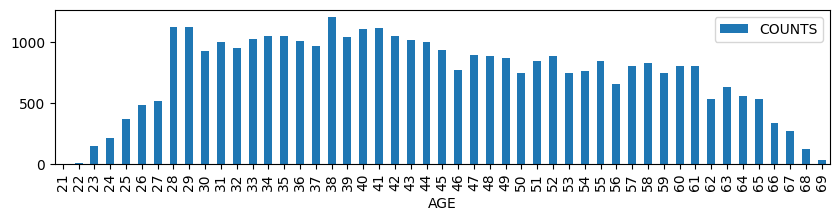

In [26]:
grouped_ages_df = application_record_sdf.group_by('AGE').agg(functions.count('AGE').as_('COUNTS')).sort('AGE')
grouped_ages_df.to_pandas().plot.bar(x='AGE', y='COUNTS', figsize=(10,2))

### Days Employment

In [27]:
application_record_sdf = application_record_sdf.with_column(
    'WORKYEAR', 
    functions.abs(functions.floor(functions.col('DAYS_EMPLOYED') / 365))
)
application_record_sdf = application_record_sdf.drop('DAYS_EMPLOYED')

<Axes: xlabel='WORKYEAR'>

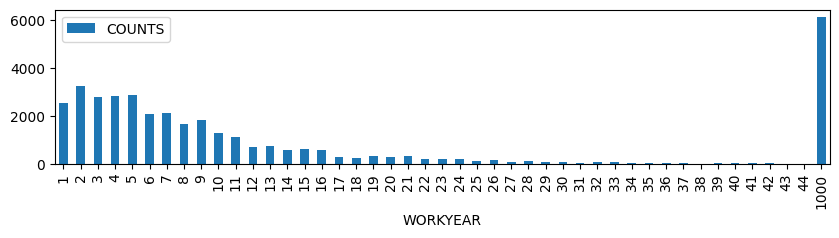

In [28]:
grouped_workyear_df = application_record_sdf.group_by('WORKYEAR').agg(functions.count('WORKYEAR').as_('COUNTS')).sort('WORKYEAR')
grouped_workyear_df.to_pandas().plot.bar(x='WORKYEAR', y='COUNTS', figsize=(10,2))

Let's filter out those with 1000 years of employment (poor sods)

In [29]:
application_record_sdf = application_record_sdf.filter(functions.col('WORKYEAR') < 50)

### Occupation
We do not need detailed level of occupation so we will group it into four diffrent categories - 
* LABOURWORK
* OFFICEWORK
* HIGHTECHWORK
* OTHER

In [30]:
var_analysis = application_record_sdf.group_by('OCCUPATION_TYPE').agg(functions.count('OCCUPATION_TYPE').as_('COUNTS')).sort('COUNTS')
var_analysis.to_pandas()

,OCCUPATION_TYPE,COUNTS
0,IT staff,60
1,Realty agents,79
2,HR staff,85
3,Secretaries,151
4,Waiters/barmen staff,174
5,Low-skill Laborers,175
6,Private service staff,344
7,Cleaning staff,551
8,Security staff,592
9,Cooking staff,655


In [31]:
# Occupation Type Groups
labour_work = [
    'Cleaning staff', 
   'Cooking staff', 
   'Drivers', 
   'Laborers', 
   'Low-skill Laborers', 
   'Security staff', 
   'Waiters/barmen staff'
]

office_work = [
    'Accountants', 
   'Core staff', 
   'HR staff', 
   'Medicine staff', 
   'Private service staff', 
   'Realty agents', 
   'Sales staff', 
   'Secretaries'
]

hightech_work = [
    'Managers', 
     'High skill tech staff', 
     'IT staff'
]

application_record_sdf = application_record_sdf.with_column(
    'OCCUPATION_TYPE',
    functions.iff(
        functions.col('OCCUPATION_TYPE').in_(labour_work), 'LABOURWORK',
        functions.iff(
            functions.col('OCCUPATION_TYPE').in_(office_work), 'OFFICEWORK',
            functions.iff(
                functions.col('OCCUPATION_TYPE').in_(hightech_work), 'HIGHTECHWORK',
                'OTHER'
            )
        )
    )
)

In [32]:
application_record_sdf.group_by('OCCUPATION_TYPE').agg(functions.count('OCCUPATION_TYPE').as_('COUNTS')).sort('OCCUPATION_TYPE').to_pandas()

,OCCUPATION_TYPE,COUNTS
0,HIGHTECHWORK,4455
1,LABOURWORK,10496
2,OFFICEWORK,10183
3,OTHER,5188


## SnowML Preprocessing

Drop redundant columns

In [33]:
application_record_sdf = application_record_sdf.drop(['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'])

In [34]:
oe_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
my_oe_encoder = OrdinalEncoder(input_cols=oe_cols, output_cols=oe_cols)
my_oe_encoder.fit(application_record_sdf)

application_record_sdf = my_oe_encoder.transform(application_record_sdf)

In [35]:
# Prepare values for One-Hot-Encoding
ohe_cols = [
    'CODE_GENDER',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'CNT_CHILDREN_IND',
    'CNT_FAM_MEMBERS_IND',
    'OCCUPATION_TYPE',
    'NAME_HOUSING_TYPE'
]

def fix_values(column):
    return functions.upper(functions.regexp_replace(functions.col(column), '[^a-zA-Z0-9]+', '_'))

my_ohe_encoder = OneHotEncoder(input_cols=ohe_cols, output_cols=ohe_cols, drop_input_cols=True)
my_ohe_encoder.fit(application_record_sdf)
application_record_sdf = my_ohe_encoder.transform(application_record_sdf)

C:\source\venv\snowpark-learnings\lib\site-packages\snowflake\snowpark\session.py:1882: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(
C:\source\venv\snowpark-learnings\lib\site-packages\snowflake\snowpark\session.py:1882: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


In [39]:
scaler_cols = ['AMT_INCOME_TOTAL', 'AGE', 'WORKYEAR']

my_scaler = StandardScaler(input_cols=scaler_cols, output_cols=scaler_cols)
my_scaler.fit(application_record_sdf)
application_record_sdf = my_scaler.transform(application_record_sdf)

In [40]:
application_record_sdf.to_pandas()

,AMT_INCOME_TOTAL,AGE,WORKYEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,CNT_CHILDREN_IND_0,CNT_CHILDREN_IND_1,CNT_CHILDREN_IND_2More,CNT_FAM_MEMBERS_IND_1,CNT_FAM_MEMBERS_IND_2,CNT_FAM_MEMBERS_IND_3More,OCCUPATION_TYPE_HIGHTECHWORK,OCCUPATION_TYPE_LABOURWORK,OCCUPATION_TYPE_OFFICEWORK,OCCUPATION_TYPE_OTHER,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_OWN_CAR,FLAG_OWN_REALTY,ID,TARGET
0,-0.783777,1.660495,0.811816,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5008852,0
1,-0.568436,0.307402,0.193361,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5008867,0
2,1.584971,0.515570,1.121043,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5008872,0
3,-0.568436,0.307402,0.193361,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5008861,0
4,0.508267,0.619654,-0.579707,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5008890,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30317,-0.783777,-1.357943,-0.425093,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5150428,0
30318,-0.783777,-0.213018,-1.043547,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5150460,0
30319,-0.783777,-0.213018,-1.043547,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5150465,0
30320,0.077586,-1.149775,-0.579707,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5150475,0


Save the transformed data into a new table

In [41]:
application_record_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED', mode='overwrite')

## Synthetic Minority Oversampling Technique (SMOTE)

https://github.com/scikit-learn-contrib/imbalanced-learn

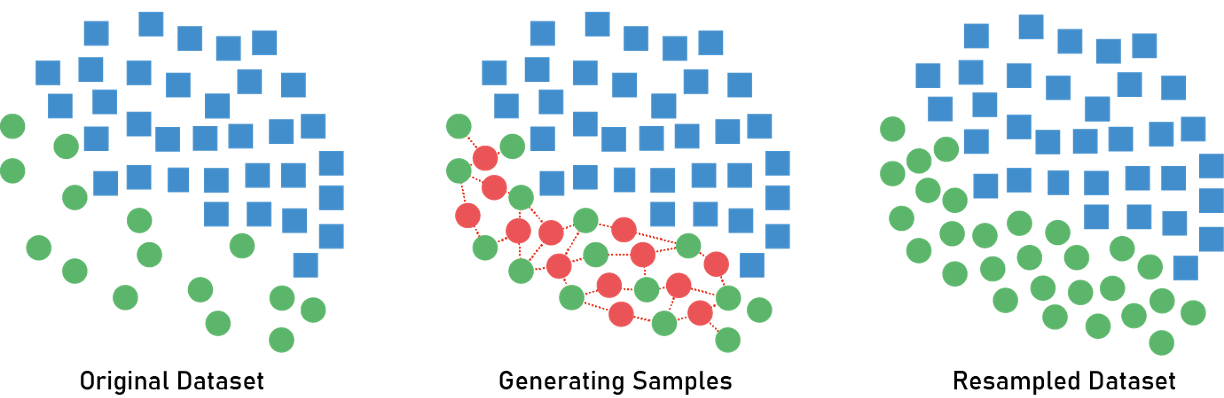

In [42]:
application_record_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|1         |503      |
|0         |29819    |
----------------------



Instead of pulling back the data localy we will create a Python Stored Procedure to do the sampling using the compute in Snowflake and save the result into a new table.

In order to create a Python Stored Procedure we need to create a Snowflake internal stage.

In [44]:
session.sql('CREATE OR REPLACE STAGE ML_PROCS').collect()

pandas.DataFrame(session.sql('SHOW STAGES').collect())

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration,endpoint,owner_role_type,directory_enabled
0,2023-11-03 16:20:55.171000+00:00,ML_PROCS,HOL_DB,PUBLIC,,N,N,USER_RL__PAUL_LUCAS,,None,INTERNAL,None,None,None,None,ROLE,N
1,2023-11-03 16:16:11.993000+00:00,assaqqcvif,HOL_DB,PUBLIC,,N,N,USER_RL__PAUL_LUCAS,,None,INTERNAL TEMPORARY,None,None,None,None,ROLE,N
2,2023-11-03 16:16:06.172000+00:00,bxnartmzxf,HOL_DB,PUBLIC,,N,N,USER_RL__PAUL_LUCAS,,None,INTERNAL TEMPORARY,None,None,None,None,ROLE,N


In [78]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_oversample_smote(session: Session, 
                           training_table: str, 
                           feature_cols: list,
                           target_col: str,
                           target_table: str) -> types.Variant:
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table)

    # Define features and label
    X = local_training_data.select(feature_cols).to_pandas()
    y = local_training_data.select(target_col).to_pandas()

    # Oversample minority class via SMOTE
    from imblearn.over_sampling import SMOTE
    X_balance, y_balance = SMOTE().fit_resample(X,y)
    
    # Combine return values into single pandas dataframe
    X_balance[target_col] = y_balance
    
    # Persist dataframe in Snowflake table
    session.sql(f'DROP TABLE IF EXISTS {target_table}').collect()
    session.write_pandas(X_balance, table_name=target_table, auto_create_table=True)
    
    # Getting model coefficients
    return "Successfully oversampled"

FYI in the lab code [here](https://github.com/Snowflake-Labs/sfguide-getting-started-machine-learning/blob/main/hol/1_3_DEMO_full_data_exploration_transformation.ipynb)

the code they provide doesn't work -

```python
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_
```

It seems that pandas doesn't accept the `feature_cols` as a list. Instead, I have it keep it as a snowpark df and then run selects against the cols neededcol]

Registering the function as a Stored Procedure. By pinning the version numbers of the the third-party python packages we makes sure that we use the same version in Snowflake as we have installed locally, otherwise the latest version avalible in the Anaconda Snowflake channel will be used

In [79]:
sproc_oversample_smote = session.sproc.register(
    func=sproc_oversample_smote, 
    name='sproc_oversample_smote', 
    is_permanent=True, 
    replace=True,
    stage_location='@ML_PROCS',
    packages=[
        f'snowflake-snowpark-python',
        f'scikit-learn==1.2.2',
        f'imbalanced-learn==0.10.1'
    ]
)

The version of package 'snowflake-snowpark-python' in the local environment is 1.9.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'imbalanced-learn' in the local environment is 0.11.0, which does not fit the criteria for the requirement 'imbalanced-learn==0.10.1'. Your UDF might not work when the package version is different between the server and your local environment.


In [80]:
training_table = 'CREDIT_RISK_PREPARED'

# get feature columns
feature_cols = application_record_sdf.columns
feature_cols.remove('TARGET')
target_col = 'TARGET'
target_table = 'CREDIT_RISK_PREPARED_BALANCED'

sproc_oversample_smote(
    training_table, 
    feature_cols, 
    target_col,
    target_table, 
    session=session
    )

'"Successfully oversampled"'

In [81]:
# Now our training data is balanced
train_data_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
train_data_sdf.group_by('TARGET').count().to_pandas()

,TARGET,COUNT
0,0,29819
1,1,29819


In [82]:
session.close()